# SGVB with MAP starting conditions

In which we try to speed up stochastic inference by starting with a MAP (Laplace) estimate.

Note, we zero out the covariances between variables, so that the starting covariance is block-diagonal, to make the procedure more stable.

In [1]:
from ptvi import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = [12, 8]

Data generation

In [2]:
data_seed, algo_seed = 123, 123  # change and rerun all

In [3]:
γ0, η0, σ0, ρ0 = 0., 2., 1.5, 0.92
true_params = {'γ': γ0, 'η': η0, 'σ': σ0, 'ρ': ρ0}
torch.manual_seed(data_seed)
y, z = LocalLevelModel(input_length=100).simulate(**true_params)

## Approximate inference with MAP starting conditions

One of the reasons this is fast is we can relax the stopping condition a bit, because we know it is already close to a reasonable answer and we can accept a higher probability of an early stop.

In [4]:
torch.manual_seed(algo_seed)
model = LocalLevelModel(input_length=100, stochastic_entropy=True, quiet=False, num_draws=1)
model.u.data, model.L.data = model.initial_conditions(y)
model.stop_heur = NoImprovementStoppingHeuristic(patience=5) # weak
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: Local level model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. ll = -1106.6174
       1. ll = -368.8921
       2. ll = -259.3536
       3. ll = -251.2206
       4. ll = -251.1201
       5. ll = -251.1201
Convergence criterion met.
       5. ll = -251.1201
Completed 6 iterations in 0.21s @ 27.99 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Local level model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=5, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displayed loss is smoothed with λ=0.1
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

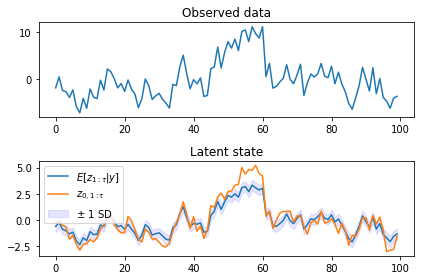

In [5]:
fit.plot_latent(true_z=z, include_data=True)

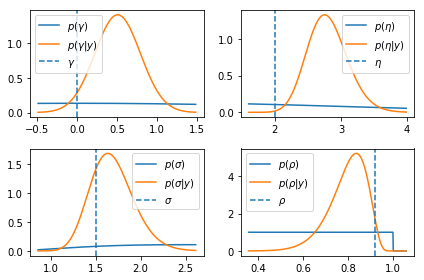

In [6]:
fit.plot_global_marginals(true_vals = true_params)

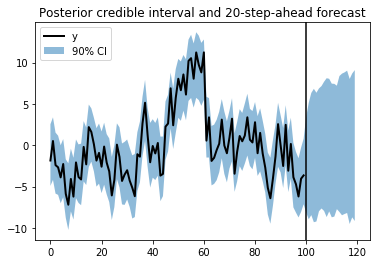

In [7]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Comparison: starting at $u=0, L=I$

### With weak stopping rule

Matches the stopping rule we used in the hybrid procedure, above.

In [8]:
torch.manual_seed(algo_seed)
model = LocalLevelModel(input_length=100, stochastic_entropy=True, quiet=False)
model.stop_heur = NoImprovementStoppingHeuristic(patience=5)  # weak
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Local level model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=5, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo_hat =   -26680.84
       1. smoothed elbo_hat =   -26918.91
       2. smoothed elbo_hat =   -24367.27
       4. smoothed elbo_hat =   -20957.89
       8. smoothed elbo_hat =   -19060.63
      16. smoothed elbo_hat =    -9250.79
      32. smoothed elbo_hat =    -3200.48
      64. smoothed elbo_hat =   -27466.32
     128. smoothed elbo_hat =   -10417.27
     256. smoothed elbo_hat =    -3079.37
     512. smoothed elbo_hat =    -3884.17
    1024. smoothed elbo_hat =    -1134.51
    2048. smoo

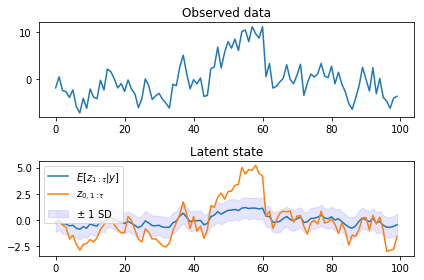

In [9]:
fit.plot_latent(true_z=z, include_data=True)

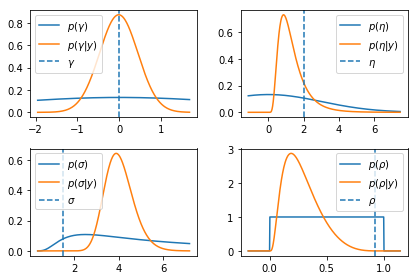

In [10]:
fit.plot_global_marginals(true_vals = true_params)

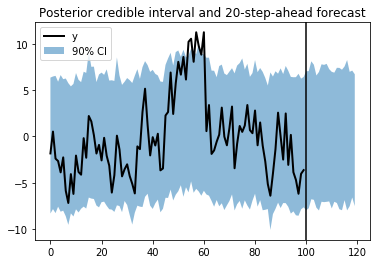

In [11]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## With strong stopping rule

This is currently the default stopping rule in my codebase

In [12]:
torch.manual_seed(algo_seed)
model = LocalLevelModel(input_length=100, stochastic_entropy=True, quiet=False)
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Local level model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo_hat =   -26680.84
       1. smoothed elbo_hat =   -26918.91
       2. smoothed elbo_hat =   -24367.27
       4. smoothed elbo_hat =   -20957.89
       8. smoothed elbo_hat =   -19060.63
      16. smoothed elbo_hat =    -9250.79
      32. smoothed elbo_hat =    -3200.48
      64. smoothed elbo_hat =   -27466.32
     128. smoothed elbo_hat =   -10417.27
     256. smoothed elbo_hat =    -3079.37
     512. smoothed elbo_hat =    -3884.17
    1024. smoothed elbo_hat =    -1134.51
    2048. smo

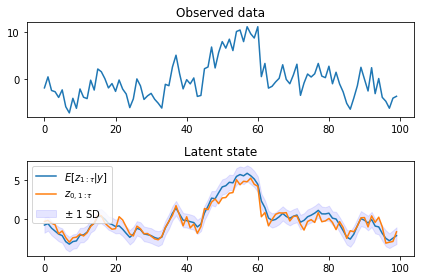

In [13]:
fit.plot_latent(true_z=z, include_data=True)

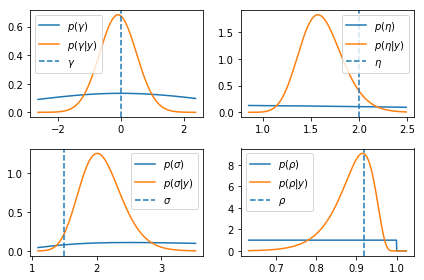

In [14]:
fit.plot_global_marginals(true_vals = true_params)

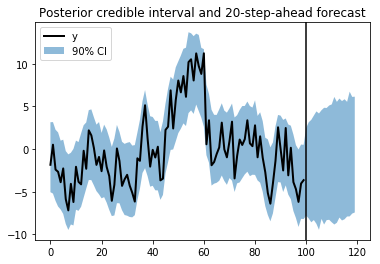

In [15]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)